In [15]:
%matplotlib inline
import requests, json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define a function that connects to API and requests y value for our x.
def get_measurement(x):
        response = requests.get("http://165.227.157.145:8080/api/do_measurement?x={0}".format(x))
        measurement = json.loads(response.content.decode('utf8'))['data']
        # Converting scalar to list (so it appears as series for DataFrame constructor)
        measurement = {x:[measurement[x]] for x in measurement.keys()}
        return measurement


# Define a function that repeatedly connects to the API and measures y across all x_values 
# with repeat number of measurements.
def get_data(x_values, repeat=10):
    
    # Create an empty pandas DataFrame that will be filled with data from the API
    df = pd.DataFrame()
    
    for x in x_values:
        for r in range(repeat):
            measurement = get_measurement(x)
            measurement['measurement_no'] = r
            df = df.append(pd.DataFrame.from_dict(measurement))
    return df
            
    
# Define broad range of x values from -1 000 000 to 1 000 000 with smaller steps for intervals closer to zero.
x_values = np.concatenate((
    np.arange(-1000000.0, -10000.0, 10000),
    np.arange(-10000.0, -1000.0, 100),
    np.arange(-1000.0, -100.0, 5),
    np.arange(-100.0, -5.0, 0.5),
    np.arange(-5.0, 5.0, 0.05),
    np.arange(5.0, 100, 0.5),
    np.arange(100.0, 1000.0, 5),
    np.arange(1000.0, 10000.0, 100),
    np.arange(10000.0, 1000000.0, 10000),    
    ), axis=0)
            
# Get the data from API and set 'x' as index
df = get_data(x_values, repeat=10)

# Save the data
df.to_csv('api_data.csv')

In [3]:
# Load the data from a file
df = pd.read_csv('api_data.csv')

# Remove all rows with nan values
df = df.dropna(axis=0, how='any')
df.head()

x             y  measurement_no
0 -1000000.0  1.000000e+24               0
1 -1000000.0  1.000000e+24               1
2 -1000000.0  1.000000e+24               2
3 -1000000.0  1.000000e+24               3
4 -1000000.0  1.000000e+24               4

In [4]:
# Convert from long to wide format
df_long = df.set_index('x').pivot(columns='measurement_no', values='y')
df_long['x'] = df_long.index

# Compute mean of all measurements
df_long['mean'] = df_long[[0,1,2,3,4,5,6,7,8,9]].mean(axis=1)
df_long.head()

measurement_no             0             1             2             3  \
x                                                                        
-1000000.0      1.000000e+24  1.000000e+24  1.000000e+24  1.000000e+24   
-990000.0       9.605960e+23  9.605960e+23  9.605960e+23  9.605960e+23   
-980000.0       9.223682e+23  9.223682e+23  9.223682e+23  9.223682e+23   
-970000.0       8.852928e+23  8.852928e+23  8.852928e+23  8.852928e+23   
-960000.0       8.493466e+23  8.493466e+23  8.493466e+23  8.493466e+23   

measurement_no             4             5             6             7  \
x                                                                        
-1000000.0      1.000000e+24  1.000000e+24  1.000000e+24  1.000000e+24   
-990000.0       9.605960e+23  9.605960e+23  9.605960e+23  9.605960e+23   
-980000.0       9.223682e+23  9.223682e+23  9.223682e+23  9.223682e+23   
-970000.0       8.852928e+23  8.852928e+23  8.852928e+23  8.852928e+23   
-960000.0       8.493466e+23  8.493466e+23  8.493466e+23  8.493466e+23   

measurement_no             8             9          x          mean  
x                                                                    
-1000000.0      1.000000e+24  1.000000e+24 -1000000.0  1.000000e+24  
-990000.0       9.605960e+23  9.605960e+23  -990000.0  9.605960e+23  
-980000.0       9.223682e+23  9.223682e+23  -980000.0  9.223682e+23  
-970000.0       8.852928e+23  8.852928e+23  -970000.0  8.852928e+23  
-960000.0       8.493466e+23  8.493466e+23  -960000.0  8.493466e+23

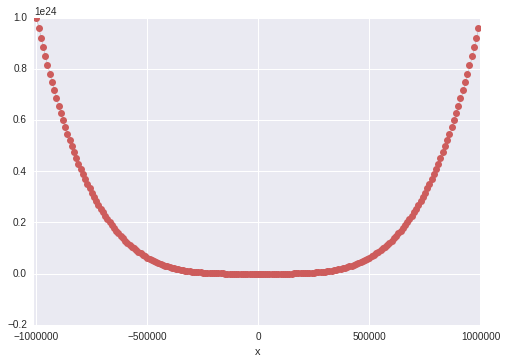

In [5]:
# Visualize all measurements throughout all x axis in tsplot
pl = sns.tsplot(data=[df_long[0], 
                 df_long[1], 
                 df_long[2], 
                 df_long[3], 
                 df_long[4], 
                 df_long[5], 
                 df_long[6], 
                 df_long[7], 
                 df_long[8], 
                 df_long[9]], 
           color="indianred", 
           time=df_long.index, 
           interpolate=False)

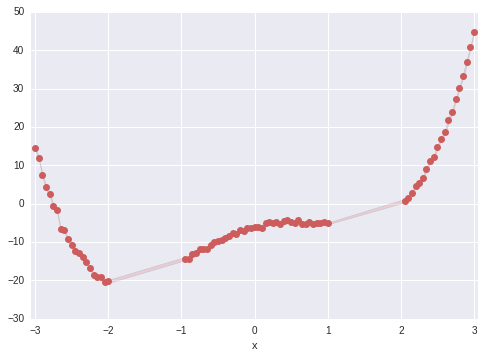

In [6]:
# Visualize just the "interesting part" of the x axis with ts plot
df_sm = df_long.loc[-3.0:3.0]
pl1 = sns.tsplot(data=[df_sm[0], 
                 df_sm[1], 
                 df_sm[2], 
                 df_sm[3], 
                 df_sm[4], 
                 df_sm[5], 
                 df_sm[6], 
                 df_sm[7], 
                 df_sm[8], 
                 df_sm[9]], 
           color="indianred", 
           time=df_sm.index, 
           interpolate=False)

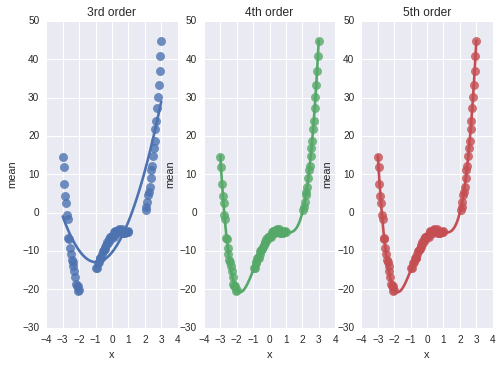

In [7]:
# Visualize the data and fit 4 order polynomial
fig1, axs = plt.subplots(ncols=3)

axs[0].set_title('3rd order')
pl3 = sns.regplot(x='x', y='mean', data=df_sm, scatter_kws={"s": 80}, order=3, ci=None, truncate=True, ax=axs[0])

axs[1].set_title('4th order')
pl4 = sns.regplot(x='x', y='mean', data=df_sm, scatter_kws={"s": 80}, order=4, ci=None, truncate=True, ax=axs[1])

axs[2].set_title('5th order')
pl5 = sns.regplot(x='x', y='mean', data=df_sm, scatter_kws={"s": 80}, order=5, ci=None, truncate=True, ax=axs[2])

# OK so now we see that 4th order polynomial fits the data nicely

In [9]:
# Compute the coeficients
coef = np.polyfit(df_sm['x'], df_sm['mean'], 4)
print('Coefficients: ({0:.4f}x^4) + ({1:.4f}x^3) + ({2:.4f}x^2) + ({3:.4f}x) + ({4:.4f})'.format(coef[0], coef[1], coef[2], coef[3], coef[4]))

rounded_coef = np.array([1, 0, -5, 5, -6])
print('Rounded coefficients: ({0:.2f}x^4) + ({1:.2f}x^3) + ({2:.2f}x^2) + ({3:.2f}x) + ({4:.2f})'.format(rounded_coef[0], rounded_coef[1], rounded_coef[2], rounded_coef[3], rounded_coef[4]))


Coefficients: (0.9925x^4) + (-0.0000x^3) + (-4.9380x^2) + (5.0169x) + (-6.0979)
Rounded coefficients: (1.00x^4) + (0.00x^3) + (-5.00x^2) + (5.00x) + (-6.00)


In [10]:
# Create predictor for coeficients
p = np.poly1d(coef)
predictions = pd.DataFrame()

# Set x range for making predictions
predictions['x'] = np.arange(-3,3.1,0.1)

# Get predictions
predictions['y'] = predictions['x'].apply(p)

print('Predicted data using computed 4th order polynomial coefficients.')
predictions.head()

Predicted data using computed 4th order polynomial coefficients.


x          y
0 -3.0  14.804495
1 -2.9   8.024428
2 -2.8   2.147460
3 -2.7  -2.894298
4 -2.6  -7.166354

In [11]:
# Create predictor for rounded coeficients
p_r = np.poly1d(coef)
predictions_r = pd.DataFrame()

# Set x range for making predictions
predictions_r['x'] = np.arange(-3,3.1,0.1)

# Get predictions
predictions_r['y'] = predictions_r['x'].apply(p)

print('Predicted data using rounded 4th order polynomial coefficients.')
predictions_r.head()

Predicted data using rounded 4th order polynomial coefficients.


x          y
0 -3.0  14.804495
1 -2.9   8.024428
2 -2.8   2.147460
3 -2.7  -2.894298
4 -2.6  -7.166354

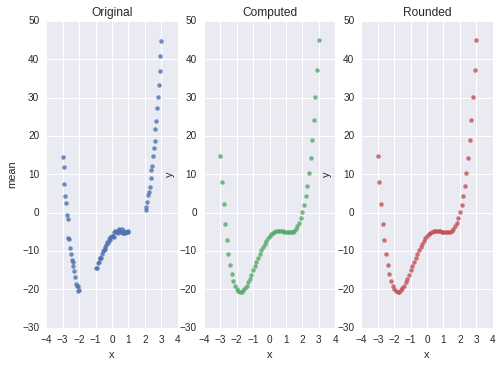

In [12]:
# Visual comparison of original data, predictions with computed coefficients and predictions with rounded coefficients

fig2, axs = plt.subplots(ncols=3)
axs[0].set_title('Original')
pl6 = sns.regplot(x="x", y="mean", data=df_sm, fit_reg=False, ax=axs[0])

axs[1].set_title('Computed')
pl7 = sns.regplot(x="x", y="y", data=predictions, fit_reg=False, ax=axs[1])

axs[2].set_title('Rounded')
pl8 = sns.regplot(x="x", y="y", data=predictions_r, fit_reg=False, ax=axs[2])


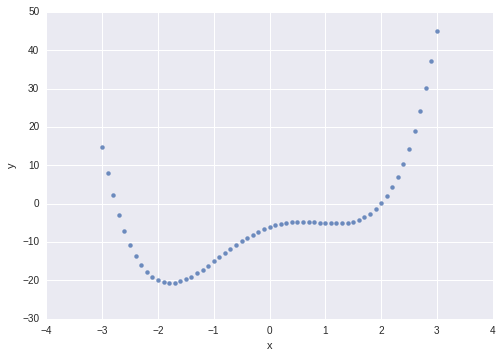

In [14]:
# Since I assume the formula was written by hand and the author did not bother 
# to specify every coefficient with 5 and more digit precision and since 
# the rounded coefficients visually provide identical results as average of 10 measurements from API,
# I assume the formula is f(x) = x^4 - 5x^2 + 5x - 6

# Resulting plot
pl9 = sns.regplot(x="x", y="y", data=predictions_r, fit_reg=False)